Description sentiment and image processing.

### Reading data

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from PIL import Image

In [2]:
df = pd.read_json('../input/train.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49352 entries, 10 to 99994
Data columns (total 15 columns):
bathrooms          49352 non-null float64
bedrooms           49352 non-null int64
building_id        49352 non-null object
created            49352 non-null object
description        49352 non-null object
display_address    49352 non-null object
features           49352 non-null object
interest_level     49352 non-null object
latitude           49352 non-null float64
listing_id         49352 non-null int64
longitude          49352 non-null float64
manager_id         49352 non-null object
photos             49352 non-null object
price              49352 non-null int64
street_address     49352 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 6.0+ MB


### Description sentiment
Let's use nltk and Vader sentiment analyzer. It takes quite a while, so I will sample only a portion of the full dataset.

In [3]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import sent_tokenize

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [4]:
def description_sentiment(sentences):
    analyzer = SentimentIntensityAnalyzer()
    result = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        result.append(vs)
    return pd.DataFrame(result).mean()

sdf = df.sample(5000)
sdf['description_tokens'] = sdf['description'].apply(sent_tokenize)
sdf = pd.concat([sdf,sdf['description_tokens'].apply(description_sentiment)],axis=1)

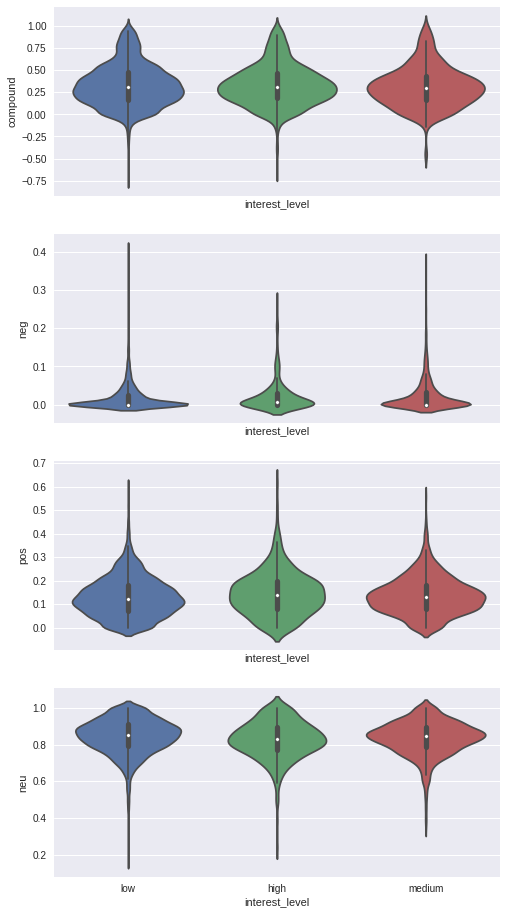

In [5]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, sharex=True,figsize=(8,16))
sns.violinplot(x="interest_level",y="compound",data=sdf,ax=ax1,order =['low','medium','high'])
sns.violinplot(x="interest_level",y="neg",data=sdf,ax=ax2)
sns.violinplot(x="interest_level",y="pos",data=sdf,ax=ax3)
sns.violinplot(x="interest_level",y="neu",data=sdf,ax=ax4)

### Photo properties

Let's also explore the possible correlations between features and simple high-level properties of images without going into NN. Let's look at the number of images, image size, brightness, hue and saturation.

In [6]:
# Get available images
from subprocess import check_output
images = [int(x) for x in check_output(["ls", "../input/images_sample"]).decode("utf8").strip().split('\n')]

# Read the train set and choose those which have images only
df = df[df.listing_id.isin(images)]
print(df.shape)

# Add number of images
df['n_images'] = df.apply(lambda x: len(x['photos']), axis=1)

(32, 15)


In [7]:
# this is what we are after
check_output(["ls", "../input/images_sample/6812223"]).decode("utf8").strip().split('\n')

['6812223_2eff74686344b0a540c9ed9fa78229b5.jpg',
 '6812223_3f6d095df3c8bde5a7da3a8939c9db1b.jpg',
 '6812223_50a885b6da2c420eba90cc63919b7104.jpg',
 '6812223_5c4d2100b140975e8fd0b29f79142b04.jpg',
 '6812223_906d2825311544e3ef052c315f4dddb7.jpg',
 '6812223_9aac0c6286ad0dcff69ecdfd3c176b49.jpg',
 '6812223_c67a947afa0e49ad6141debe0dac4d13.jpg',
 '6812223_cb780cdea1cdf9ab27d5b3cfb958ef58.jpg',
 '6812223_f94de141c6d2e3c7cbebc4b4ee6425b4.jpg']

In [8]:
#function to process one image
def process_image(path):
    path = '../input/images_sample/'+path[0:7]+'/'+path
    im = np.array(Image.open(path))

    #get dims
    width = im.shape[1]
    height = im.shape[0]
    
    #flatten image
    im = im.transpose(2,0,1).reshape(3,-1)
   
    
    #brightness is simple, assign 1 if zero to avoid divide
    brg = np.amax(im,axis=0)
    brg[brg==0] = 1
    
    #hue, same, assign 1 if zero, not working atm due to arccos
    denom = np.sqrt((im[0]-im[1])**2-(im[0]-im[2])*(im[1]-im[2]))
    denom[denom==0] = 1
    #hue = np.arccos(0.5*(2*im[0]-im[1]-im[2])/denom)
    
    #saturation
    sat = (brg - np.amin(im,axis=0))/brg
    
    #return mean values
    return width,height,np.mean(brg),np.mean(sat)

In [9]:
#second helper function - process a row of a dataset
#return mean of each property for all images
def process_row(row):
    images = check_output(["ls", "../input/images_sample/"+str(row.listing_id)]).decode("utf8").strip().split('\n')
    res = np.array([process_image(x) for x in images])
    res = np.mean(res,axis=0)
    row['img_width'] = res[0]
    row['img_height'] = res[1]
    row['img_brightness'] = res[2]
    row['img_saturation'] = res[3]
    return row

In [10]:
#Now we can process the dataset
df = df.apply(lambda row: process_row(row),axis=1)

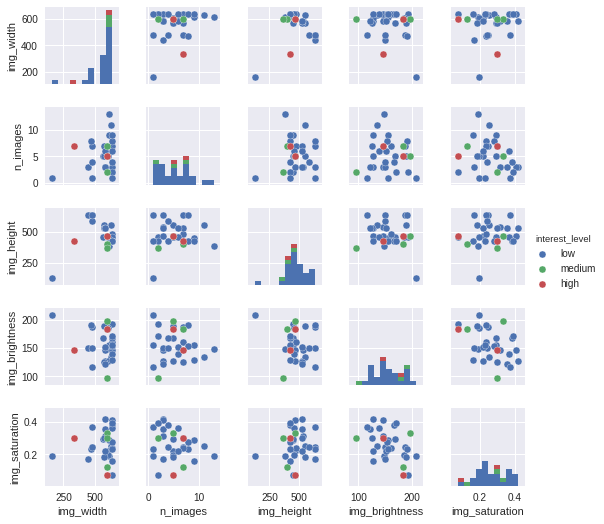

In [11]:
#Some plots
d = df[['img_width','n_images','img_height','img_brightness','img_saturation','interest_level']]
sns.pairplot(d, hue="interest_level",size=1.5)

Looks like it is all over the place, so it is unlikely to be a good feature. It is easy to calculate so perhaps still worth a try on a full image dataset.